Este cuaderno es una demo del modulo _Simulador_ y el modulo de optizacion (_Workforce_), que usa este para computar una estrategia optima. 

# Simulador (noviembre 2023)
## para simulación: simv06


<Axes: >

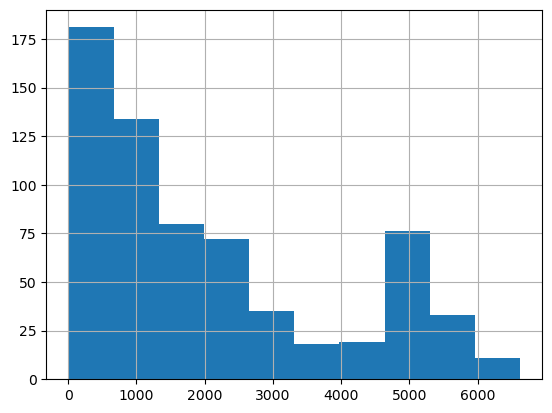

In [4]:
import os

os.chdir("/DeepenData/Repos/Flux_v0")
from dev.simv06 import simv06, plan_desde_skills
from src.utils_Escritoriosv05_Simv05 import DatasetTTP, obtener_skills
import warnings

warnings.filterwarnings("ignore")

dataset = DatasetTTP.desde_csv_atenciones("data/fonasa_monjitas.csv.gz")  # IdOficina=2)
un_dia = dataset.un_dia("2023-05-15").sort_values(by="FH_Emi", inplace=False)
skills = obtener_skills(un_dia)
max(un_dia.T_Esp)
un_dia.T_Esp.hist()

In [5]:
planificacion = plan_desde_skills(skills, inicio="08:00:00", porcentaje_actividad=.85)
planificacion

{'7': [{'inicio': '08:00:00',
   'termino': None,
   'propiedades': {'skills': [10, 12],
    'configuracion_atencion': 'Alternancia',
    'porcentaje_actividad': 0.85,
    'atributos_series': [{'serie': 5,
      'sla_porcen': 80,
      'sla_corte': 603,
      'pasos': 1,
      'prioridad': 1},
     {'serie': 10,
      'sla_porcen': 84,
      'sla_corte': 1782,
      'pasos': 4,
      'prioridad': 4},
     {'serie': 11,
      'sla_porcen': 84,
      'sla_corte': 1526,
      'pasos': 2,
      'prioridad': 2},
     {'serie': 12,
      'sla_porcen': 74,
      'sla_corte': 1479,
      'pasos': 3,
      'prioridad': 5},
     {'serie': 14,
      'sla_porcen': 80,
      'sla_corte': 1434,
      'pasos': 4,
      'prioridad': 3},
     {'serie': 17,
      'sla_porcen': 77,
      'sla_corte': 1705,
      'pasos': 2,
      'prioridad': 6}]}}],
 '10': [{'inicio': '08:00:00',
   'termino': None,
   'propiedades': {'skills': [17, 14],
    'configuracion_atencion': 'Alternancia',
    'porcentaje_activ

len(registros_atenciones) = 659, len(fila) = 0
tiempo total: 3.6 segundos


<Axes: >

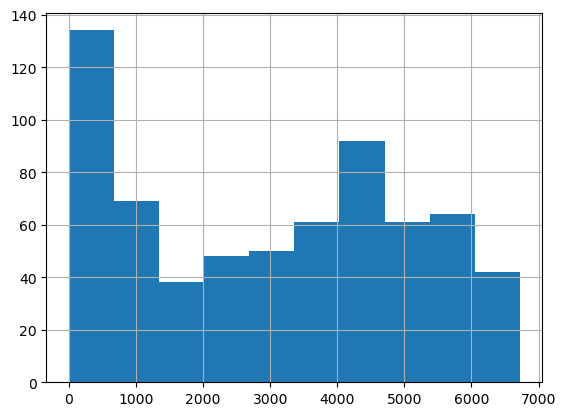

In [6]:
import time

start_time = time.time()
hora_cierre = "15:30:00"
registros_atenciones, fila = simv06(
    un_dia, hora_cierre, planificacion
)  # ==== CODIGO MIY IMPOPRTANTE ====
print(f"{len(registros_atenciones) = }, {len(fila) = }")
end_time = time.time()
print(f"tiempo total: {end_time - start_time:.1f} segundos")
max(registros_atenciones.espera)
registros_atenciones.espera.hist()

<Axes: xlabel='FH_Emi', ylabel='FH_Llama'>

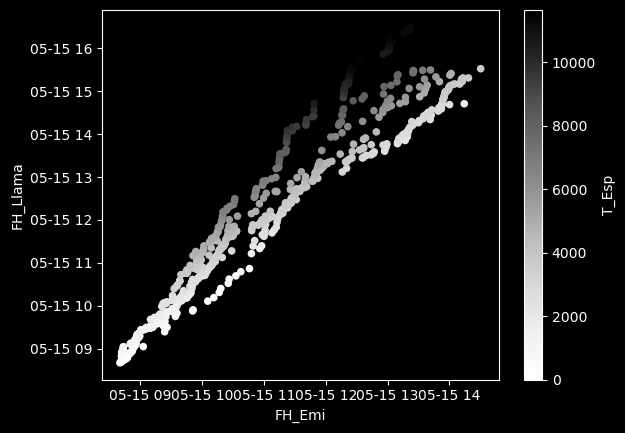

In [3]:
import pandas as pd

IdOficina: int = 2  # Se le pasa arriba, pero no creo que lo usaba para nada


def formatea_tabla_simulador(df: pd.DataFrame) -> pd.DataFrame:
    df["IdOficina"] = IdOficina
    df["FH_AteIni"] = df["FH_Emi"].astype("datetime64[s]") + pd.to_timedelta(
        df["espera"], unit="seconds"
    )
    df["FH_Llama"] = df["FH_AteIni"]  # BUG: posiblemente no necesario
    df["FH_AteFin"] = df["FH_AteIni"] + pd.to_timedelta(df["T_Ate"], unit="seconds")

    df = df.rename(columns={"espera": "T_Esp"})

    return df[
        [
            "IdOficina",
            "IdSerie",
            "IdEsc",
            "FH_Emi",
            "FH_Llama",
            "FH_AteIni",
            "FH_AteFin",
            "T_Esp",
            "T_Ate",
        ]
    ]


# IdOficina	IdSerie	IdEsc	FH_Emi	FH_Llama	FH_AteIni	FH_AteFin	T_Esp	T_Ate
formatea_tabla_simulador(registros_atenciones).astype(
    {"IdSerie": "category"}
).plot.scatter(x="FH_Emi", y="FH_Llama", c="T_Esp")

# Workforce manager

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import random
import optuna
from src.datos_utils import DatasetTTP, obtener_skills
from src.optuna_utils import non_empty_subsets
import itertools
import numpy as np
from src.optuna_utils import plan_unico
from dev.atributos_de_series import atributos_x_serie
import optuna
import numpy as np
import time
from src.optuna_utils import (
    sla_x_serie, 
    extract_skills_length, 
    non_empty_subsets
    )
from   src.utils_Escritoriosv05_Simv05 import (
                                            get_permutations_array,
                                           plan_unico,
                                           generar_planificacion,
                                           extract_min_value_keys,
                                            DatasetTTP,
                                            get_time_intervals,
                                            partition_dataframe_by_time_intervals)
from dev.Escritoriosv05_Simv05 import simv05
from dev.atributos_de_series import atributos_x_serie
import math

def objective(trial, 
    un_dia : pd.DataFrame,  # IdOficina  IdSerie  IdEsc, FH_Emi, FH_Llama  -- Deberia llamarse 'un_tramo'
    subsets: list, # [(5,), (10,), (11,), (12,), (14,), (17,), (5, 10), (5, 11), (5, 12), (5, 14), (5, 17), (10, 11),  <...> 14, 17), (5, 10, 12, 14, 17), (5, 11, 12, 14, 17), (10, 11, 12, 14, 17), (5, 10, 11, 12, 14, 17)]
    hora_cierre:str,
    modos_atenciones : list = ["Alternancia", "FIFO", "Rebalse"],
    pesos_x_serie: dict = None,
    optimizar: str = "SLA",
    minimo_escritorios: int = 2,
    maximo_escritorios: int = 5,
    niveles_servicio_x_serie = None,
    series                   : list = None
    ):    
    all_permutations = list(itertools.permutations([r+1 for r in range(len(series))]))
    try:
        
        n_escritorios = trial.suggest_int(
             f'prioridades', minimo_escritorios, maximo_escritorios )
        print(f"---------------------n_escritorios {n_escritorios}")
        #bool_vector              = [trial.suggest_categorical(f'escritorio_{i}', [True, False]) for i in range(n_escritorios)]
        #Restricción de minimo de escritorios
        #assert sum(bool_vector) >= minimo_escritorios, f"No cumple con minimo_escritorios: {minimo_escritorios}."
        
        str_dict                 = {i: trial.suggest_categorical(f'{i}',         modos_atenciones) for i in range(n_escritorios)} 
        subset_idx               = {i: trial.suggest_int(f'ids_{i}', 0, len(subsets) - 1) for i in range(n_escritorios)}   
        #prioridades              =  prioridad_x_serie(niveles_servicio_x_serie, 2, 1) 
        planificacion_optuna            =  {} # Arma una planificacion con espacios parametricos. 
        inicio                   =  str(un_dia.FH_Emi.min().time())#'08:33:00'
        termino                  =  str(un_dia.FH_Emi.max().time())#'14:33:00'        
        #skills_len = len(list(subsets[subset_idx[key]]))        
        for key in str_dict.keys():
            #if bool_vector[key]:
                #skills                    = list(subsets[subset_idx[key]])
                #permutaciones_prioridades = get_permutations_array(list(subsets[subset_idx[key]]).__len__())
                inner_dict = {
                    'inicio': inicio,
                    'termino': termino,
                    'propiedades': {
                        'skills': list(subsets[subset_idx[key]]),# list(subsets[subset_idx[key]]), # Set -> Lista, para el subset 'subset_idx', para el escritorio 'key'
                        'configuracion_atencion': str_dict[key], # 
                        'prioridades': 
                                    {s: r for s,r in zip(series, all_permutations
                                    [trial.suggest_int('idx', 0, len(all_permutations) - 1)])}
                                  ,
                        'pasos': {i: trial.suggest_int(f'pasos_{i}', 1, 4) for i in list(subsets[subset_idx[key]])},
                    }
                }
                planificacion_optuna[str(key)] = [inner_dict] # NOTE: Es una lista why -- Config por trial por tramo del escritorio 
                
                
                

                
        planificacion = {un_escritorio[0]:
                [
                    {
                    'inicio': un_escritorio[1][0]['inicio'],
                'termino':un_escritorio[1][0]['termino'],
                'propiedades':{
                    'skills': un_escritorio[1][0]['propiedades']['skills'],
                'configuracion_atencion': un_escritorio[1][0]['propiedades']['configuracion_atencion'],
                'porcentaje_actividad'  : np.random.randint(85, 90)/100,                
                'atributos_series':
                    atributos_x_serie(ids_series=un_escritorio[1][0]['propiedades']['skills'], 
                                                sla_porcen_user=[niveles_servicio_x_serie[s][0] for s in un_escritorio[1][0]['propiedades']['skills']]
            , 
                                                sla_corte_user=[niveles_servicio_x_serie[s][1] for s in un_escritorio[1][0]['propiedades']['skills']]
            , 
                                                pasos_user=list(un_escritorio[1][0]['propiedades']['pasos'].values()), 
                                                prioridades_user=list(un_escritorio[1][0]['propiedades']['prioridades'].values())),
                },}]
                for un_escritorio in planificacion_optuna.items()}

                        
        trial.set_user_attr('planificacion', planificacion) # This' actually cool 
        
        
        nested_list =  [e[0]['propiedades']['skills'] for k, e in  planificacion.items()]
        assert set([item for sublist in nested_list for item in sublist]) == set(series), "no todas las series incluidas"
        
        registros_atenciones, _      = simv05(un_dia, hora_cierre, planificacion)   
        registros_atenciones['IdSerie'] = registros_atenciones['IdSerie'].astype(int) 
        registros_x_serie               = [registros_atenciones[registros_atenciones.IdSerie==s] for s in series]
        pocentajes_SLA        = [int(100*v[0])for k,v in niveles_servicio_x_serie.items()]
        mins_de_corte_SLA     = [int(v[1])for k,v in niveles_servicio_x_serie.items()]        
        df_pairs              = [(sla_x_serie(r_x_s, '1H', corte = corte), s) 
                                 for r_x_s, s, corte in zip(registros_x_serie, series, mins_de_corte_SLA)]
        porcentajes_reales    = {f"serie: {serie}": np.mean(esperas.espera) for ((demandas, esperas), serie) in df_pairs} 
        
        
        assert not any(math.isnan(x) for x in [v for k, v in porcentajes_reales.items()]), "porcentajes_reales contains at least one nan"

        
        print(f"------------porcentajes_reales {[v for k, v in porcentajes_reales.items()]}")
        print(f"----------------pocentajes_SLA :{pocentajes_SLA}")
        #print(f"sla_real: {sla_real} - sla_teorico {sla_teorico}")
        dif_cuadratica        = {k:((sla_real-sla_teorico)**2 if sla_real < sla_teorico else abs((sla_real-sla_teorico)) ) 
                                 for ((k,sla_real),sla_teorico) in zip(porcentajes_reales.items(),pocentajes_SLA)}
        #Objetivos:    
        #La mayor prioridad es el entero más chico    
        maximizar_SLAs        = tuple(np.array(tuple(pesos_x_serie.values()))*np.array(tuple(dif_cuadratica.values())))#Ponderado por prioridad
        minimizar_escritorios = (10*n_escritorios**2,)
        minimizar_skills      = (extract_skills_length(planificacion)**2,)
        
        
        
        assert not any(math.isnan(x) for x in maximizar_SLAs), "al menos un SLA NaN"
        
        if optimizar == "SLA":
            
            print(f"--OBJ-- maximizar_SLAs           {maximizar_SLAs}")
            return  maximizar_SLAs
        
        elif optimizar == "SLA + escritorios":
            
            print(f"maximizar_SLAs y minimizar_escritorios { maximizar_SLAs + minimizar_escritorios}")
            return  maximizar_SLAs + minimizar_escritorios
        
        elif optimizar == "SLA + skills":
            
            print(f"maximizar_SLAs y minimizar_skills {maximizar_SLAs + minimizar_skills}")
            return  maximizar_SLAs + minimizar_skills
        
        elif optimizar == "SLA + escritorios + skills":
            
            print(f"SLA + escritorios + skills {maximizar_SLAs + minimizar_escritorios + minimizar_skills}")
            return  maximizar_SLAs + minimizar_escritorios + minimizar_skills        
    except Exception as e:
        print(f"An exception occurred: {e}")
        raise optuna.TrialPruned()
    
dataset                                 = DatasetTTP.desde_csv_atenciones("data/fonasa_monjitas.csv.gz") # IdOficina=2)
un_dia                                  = dataset.un_dia("2023-05-15").sort_values(by='FH_Emi', inplace=False)
skills       = obtener_skills(un_dia)
series       = sorted(list({val for sublist in skills.values() for val in sublist}))
atributos_series = atributos_x_serie(ids_series=series, 
                                    sla_porcen_user=None, 
                                    sla_corte_user=None, 
                                    pasos_user=None, 
                                    prioridades_user=None)
niveles_servicio_x_serie = {atr_dict['serie']:
                            (atr_dict['sla_porcen']/100, atr_dict['sla_corte']) 
                            for atr_dict in atributos_series}

intervals  = get_time_intervals(un_dia, n = 4, porcentaje_actividad = 1) # Una funcion que recibe un dia, un intervalo, y un porcentaje de actividad para todos los intervalos
partitions = partition_dataframe_by_time_intervals(un_dia, intervals) # TODO: implementar como un static del simulador? 
storage = optuna.storages.get_storage("sqlite:///alejandro_objs_v05.db")
n_trials     = 5
optimizar    ="SLA" #"SLA + escritorios + skills" #"SLA" | "SLA + escritorios" | "SLA + skills" | "SLA + escritorios + skills"
n_objs       = int(
                        len(series)
                        if optimizar == "SLA"
                        else len(series) + 1
                        if optimizar in {"SLA + escritorios", "SLA + skills"}
                        else len(series) + 2
                        if optimizar == "SLA + escritorios + skills"
                        else None
                        )
pesos_x_serie = {s: random.randint(1,len(series)) for s in series}
for idx, (part, inters) in enumerate(zip(partitions,intervals)):
    print(inters)
    #print(idx, part, inters[1])
    
    study_name = f"tramo_{idx}"
    study = optuna.multi_objective.create_study(directions= n_objs*['minimize'],
                                                study_name=study_name,
                                                storage=storage, load_if_exists=True)
    # TODO: sacar fuera
    # Optimize with a timeout (in seconds)
    
    subsets      = non_empty_subsets(sorted(list({val for sublist in obtener_skills(part).values() for val in sublist})))

    
    study.optimize(lambda trial: objective(trial,
                                           optimizar                = optimizar,
                                           un_dia                   = part,
                                           subsets                  = subsets,
                                           hora_cierre              =  inters[1],
                                           pesos_x_serie            = pesos_x_serie,
                                           minimo_escritorios       = 10,
                                           maximo_escritorios       = 13,
                                           niveles_servicio_x_serie = niveles_servicio_x_serie,
                                           series                   = sorted(list({val for sublist in obtener_skills(part).values() for val in sublist}))   
                                           ),
                   n_trials  = n_trials, #int(1e4),  # Make sure this is an integer
                   timeout   = 2*3600,   #  hours
                   )  # 

## Extracción de la planificación óptima

In [ ]:
recomendaciones_db   = optuna.storages.get_storage("sqlite:///alejandro_objs_v05.db") # Objetivos de 6-salidas
resumenes            = optuna.study.get_all_study_summaries(recomendaciones_db)
nombres              = [s.study_name for s in resumenes if "tramo_" in s.study_name]

scores_studios = {}
for un_nombre in nombres:
    un_estudio            = optuna.multi_objective.load_study(study_name=un_nombre, storage=recomendaciones_db)
    trials_de_un_estudio  = un_estudio.get_trials(deepcopy=False) #or pareto trials??
    scores_studios        = scores_studios | {f"{un_nombre}":
        { trial.number: np.mean([x for x in trial.values if x is not None]) 
                for
                    trial in trials_de_un_estudio if trial.state == optuna.trial.TrialState.COMPLETE}
                    } 
    
trials_optimos          = extract_min_value_keys(scores_studios) # Para cada tramo, extrae el maximo, 
planificaciones_optimas = {}   
for k,v in trials_optimos.items():
    un_estudio               = optuna.multi_objective.load_study(study_name=k, storage=recomendaciones_db)
    trials_de_un_estudio     = un_estudio.get_trials(deepcopy=False)
    planificaciones_optimas  = planificaciones_optimas | {f"{k}":
        trial.user_attrs.get('planificacion')#calcular_optimo(trial.values)
                for
                    trial in trials_de_un_estudio if trial.number == v[0]
                    }   
    
planificacion_optima   =  plan_unico([plan for tramo,plan in planificaciones_optimas.items()])

### simulación con planificación óptima

In [ ]:
hora_cierre = "17:00:00"
registros_atenciones, fila =  simv05(un_dia, hora_cierre, planificacion_optima) 
print(f"{len(registros_atenciones) = }, {len(fila) = }")